In [39]:
import desc.imsim as imsim
import lsst.sims.GalSimInterface as GSInterface
from lsst.sims.photUtils import PhotometricParameters
from lsst.sims.utils import ObservationMetaData
%pylab inline
import sys
import time
import galsim

instantiate PhotometricParameters object and ObservationMetaData object to create detector objects later

In [ ]:
pp = PhotometricParameters(bandpass='r', darkcurrent=0, exptime=30, gain=1, nexp=1, readnoise=0)

In [150]:
md = ObservationMetaData(boundType='circle', boundLength=1, pointingRA=1.5828532048284123,
                        pointingDec=0.18741449478729227, rotSkyPos=141.78786020874185,
                        mjd=61342.03846061111, bandpassName='g', skyBrightness=None)

In [152]:
md.OpsimMetaData = {'obshistID': 1202251,
  'FWHMgeom': 0.6076686217172226,
  'FWHMeff': 0.6759958901669374,
  'rawSeeing': 0.31125,
  'altitude': 53.11193370664552}

all the things that went into ObservationMetaData was all copied into here after running `imsim.ImageSimulator()` on an InstanceCatalog

In [153]:
md.summary

{'site': <lsst.sims.utils.Site.Site at 0x2ac8f5639860>,
 'boundType': 'circle',
 'boundLength': 1.0,
 'pointingRA': 1.5828532048284123,
 'pointingDec': 0.18741449478729227,
 'rotSkyPos': 141.78786020874185,
 'mjd': 61342.03846061111,
 'bandpass': 'g',
 'skyBrightness': None,
 'OpsimMetaData': {'obshistID': 1202251,
  'FWHMgeom': 0.6076686217172226,
  'FWHMeff': 0.6759958901669374,
  'rawSeeing': 0.31125,
  'altitude': 53.11193370664552}}

create an lsst camera object

In [88]:
camera = imsim.get_obs_lsstSim_camera()

In [89]:
camera.getName()

'LSST'

In [101]:
interpreter = GSInterface.GalSimInterpreter(detectors=list(camera))

create lsst cameraWrapper

In [132]:
cameraWrapper = GSInterface.LSSTCameraWrapper()

create detector objects

In [165]:
detectors = [GSInterface.make_galsim_detector(cameraWrapper, det.getName(), pp, md) for det in list(camera) if det.getType()==DetectorType.SCIENCE] 

create blank images with correct lsst pixel geometry and wcs

In [ ]:
imgs = [interpreter.blankImage(det) for det in detectors] 

In [ ]:
img = imgs[0]

now using one of the images to set wcs, nx, ny. the two following cells use the code from 

In [257]:
%%time
# most of this is from galsim's treering flats code
# Put the salient numbers up here so they are easy to adjust.
counts_per_iter = 20.e3  # a few thousand is probably fine.  (bigger is faster of course.) -- HA: changed this from 2k
counts_total = 80.e3    #  80K flats
nx = img.xmax
ny = img.ymax
nborder = 2
nflats = 1
treering_amplitude = 0.26
treering_period = 47.
treering_center = galsim.PositionD(0,0)
seed = 31415


# This is very similar to treering_skybg2.py, which builds a sky image.
# But here we build up to a much higher flux level where B/F is important.

rng = galsim.UniformDeviate(seed)

treering_func = galsim.SiliconSensor.simple_treerings(treering_amplitude, treering_period)

niter = int(counts_total / counts_per_iter + 0.5)
counts_per_iter = counts_total / niter  # Recalculate in case not even multiple.
print('Total counts = {} = {} * {}'.format(counts_total,niter,counts_per_iter))

# an LSST wcs
wcs = img.wcs

base_image = galsim.ImageF(nx+2*nborder, ny+2*nborder, wcs=wcs)
print('image bounds = ',base_image.bounds)

# nrecalc is actually irrelevant here, since a recalculation will be forced on each iteration.
# Which is really the point.  We need to set coundsPerIter appropriately so that the B/F effect
# doesn't change *too* much between iterations.
sensor = galsim.SiliconSensor(rng=rng,
                              treering_func=treering_func, treering_center=treering_center)

# We also need to account for the distortion of the wcs across the image.  
# This expects sky_level in ADU/arcsec^2, not ADU/pixel.
base_image.wcs.makeSkyImage(base_image, sky_level=1.)
base_image.write('wcs_area.fits')

# Rescale so that the mean sky level per pixel is skyCounts
mean_pixel_area = base_image.array.mean()

sky_level_per_iter = counts_per_iter / mean_pixel_area  # in ADU/arcsec^2 now.
base_image *= sky_level_per_iter

# The base_image has the right level to account for the WCS distortion, but not any sensor effects.
# This is the noise-free level that we want to add each iteration modulated by the sensor.

noise = galsim.PoissonNoise(rng)

Total counts = 80000.0 = 4 * 20000.0
image bounds =  galsim.BoundsI(1,4004,1,4076)
CPU times: user 3min 5s, sys: 13.2 s, total: 3min 19s
Wall time: 3min 17s


In [258]:
%%time
# most of this is from galsim's treering flats code

for n in range(nflats):
    # image is the image that we will build up in steps.
    # We add on a border of 2 pixels, since the outer row/col get a little messed up by photons
    # falling off the edge, but not coming on from the other direction.
    # We do 2 rows/cols rather than just 1 to be safe
    
    image = galsim.ImageF(nx+2*nborder, ny+2*nborder, wcs=wcs)

    for i in range(niter):
        # temp is the additional flux we will add to the image in this iteration.
        # Start with the right area due to the sensor effects.
        temp = sensor.calculate_pixel_areas(image)
        temp = temp
        temp /= np.mean(temp.array)  # Normalize to unit mean.
        # temp.write('sensor_area.fits')

        # Multiply by the base image to get the right mean level and wcs effects
        temp *= base_image
        # temp.write('nonoise.fits')

        # Finally, add noise.  What we have here so far is the expectation value in each pixel.
        # We need to realize this according to Poisson statistics with these means.
        temp.addNoise(noise)
        # temp.write('withnoise.fits')
    
        # Add this to the image we are building up.
        image += temp

    # Cut off the outer border where things don't work quite right.
    print('bounds = ',image.bounds)
    image = image.subImage(galsim.BoundsI(1+nborder,nx+nborder,1+nborder,ny+nborder))
    print('bounds => ',image.bounds)
    image.setOrigin(1,1)
    print('bounds => ',image.bounds)

    image.write('flat{:02d}.fits'.format(n))

bounds =  galsim.BoundsI(1,4004,1,4076)
bounds =>  galsim.BoundsI(3,4002,3,4074)
bounds =>  galsim.BoundsI(1,4000,1,4072)
CPU times: user 4min 50s, sys: 17.3 s, total: 5min 7s
Wall time: 5min 7s


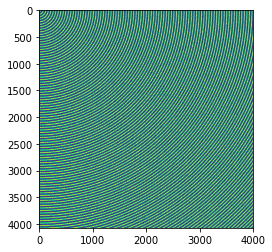

In [260]:
plt.imshow(image.array)